# **Imports**

In [1]:
import torch
import numpy as np
import pandas as pd
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
sns.set(style="darkgrid")
sns.set_palette("husl")
scaler = MinMaxScaler(feature_range=(-1, 1))
torch.manual_seed(27)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

device

'cpu'

# **Initializing**

In [204]:
data = pd.read_csv('data/Traffic%20Accidents%201%3A11(1).csv',parse_dates=['Date '],dayfirst=True)
accidents_per_year = data.groupby('Year').size().reset_index(name='Accidents')

In [205]:
fatalities_per_year = datafatalities_per_year= data.groupby(['Year','Fatalties'])['Fatalties'].sum().reset_index(name='Fatalities').groupby('Year')['Fatalities'].sum().reset_index(name='Fatalities')

# **Preprocessing**

In [206]:
def prepare_dataframe_for_lstm(n_steps, columns=[]):


    for i in range(1, n_steps + 1):
        accidents_per_year[f"Accidents(t-{i})"] = accidents_per_year[columns[0]].shift(i)
        fatalities_per_year[f"Fatalities(t-{i})"] = fatalities_per_year[columns[1]].shift(i)
    accidents_per_year.dropna(inplace=True)
    fatalities_per_year.dropna(inplace=True)

    df = pd.merge(accidents_per_year,fatalities_per_year,on='Year')

    return df


lookback = 2
shifted_df = prepare_dataframe_for_lstm(
    lookback, ["Accidents","Fatalities"]
)

In [207]:
shifted_df.set_index('Year',inplace=True)

In [208]:
shifted_df['Pandemic_Indicator'] = 0  # Initialize the indicator column with zeros
pandemic_start_year = 2020

# Set the indicator value to 1 for the pandemic period (years 2020 and onwards)
shifted_df.loc[shifted_df.index >= pandemic_start_year, 'Pandemic_Indicator'] = 1
post_pandemic_start_year = 2021
shifted_df.loc[shifted_df.index >= post_pandemic_start_year, 'Pandemic_Indicator'] = 0.5

In [209]:
shifted_df

,Accidents,Accidents(t-1),Accidents(t-2),Fatalities,Fatalities(t-1),Fatalities(t-2),Pandemic_Indicator
Year,,,,,,,
2012,1950,1868.0,1984.0,274,280.0,339.0,0.0
2013,1902,1950.0,1868.0,232,274.0,280.0,0.0
2014,1912,1902.0,1950.0,230,232.0,274.0,0.0
2015,1901,1912.0,1902.0,261,230.0,232.0,0.0
2016,1793,1901.0,1912.0,231,261.0,230.0,0.0
2017,1719,1793.0,1901.0,240,231.0,261.0,0.0
2018,1745,1719.0,1793.0,260,240.0,231.0,0.0
2019,1732,1745.0,1719.0,242,260.0,240.0,0.0
2020,1208,1732.0,1745.0,159,242.0,260.0,1.0


In [210]:
column_to_move = 'Fatalities'
new_position = 1  # Index where you want to insert the column

# Remove the column from its current position
column = shifted_df.pop(column_to_move)

# Insert the column at the desired position
shifted_df.insert(new_position, column_to_move, column)

In [211]:
shifted_df.to_numpy()[:,:-1]

array([[1950.,  274., 1868., 1984.,  280.,  339.],
       [1902.,  232., 1950., 1868.,  274.,  280.],
       [1912.,  230., 1902., 1950.,  232.,  274.],
       [1901.,  261., 1912., 1902.,  230.,  232.],
       [1793.,  231., 1901., 1912.,  261.,  230.],
       [1719.,  240., 1793., 1901.,  231.,  261.],
       [1745.,  260., 1719., 1793.,  240.,  231.],
       [1732.,  242., 1745., 1719.,  260.,  240.],
       [1208.,  159., 1732., 1745.,  242.,  260.],
       [1447.,  192., 1208., 1732.,  159.,  242.]])

In [212]:
shifted_df_as_np = shifted_df.to_numpy()

In [213]:
shifted_df_as_np[:,:-1] = scaler.fit_transform(shifted_df_as_np[:,:-1])

In [214]:
X = shifted_df_as_np[:, 2:]
y = shifted_df_as_np[:, :2]

X.shape, y.shape

((10, 5), (10, 2))

In [215]:
X = dc(np.flip(X, axis=1))

In [238]:
split_index = int(X.shape[0] * 0.9)
split_index

9

# **Data Preparation**

In [239]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9, 5), (1, 5), (9, 2), (1, 2))

In [240]:
X_train = X_train.reshape((-1, (lookback*2 )+1, 1))
X_test = X_test.reshape((-1, (lookback*2) +1, 1))

y_train = y_train.reshape((-1, 2))
y_test = y_test.reshape((-1, 2))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9, 5, 1), (1, 5, 1), (9, 2), (1, 2))

In [241]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9, 5, 1]),
 torch.Size([1, 5, 1]),
 torch.Size([9, 2]),
 torch.Size([1, 2]))

In [242]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

torch.manual_seed(27)
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [243]:
batch_size = 1
torch.manual_seed(27)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [244]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    print(x_batch)
    break

torch.Size([1, 5, 1]) torch.Size([1, 2])
tensor([[[ 0.0000],
         [-0.9817],
         [ 0.3388],
         [-0.4415],
         [ 0.3774]]])


In [245]:
x_batch[:,1:]

tensor([[[-0.9817],
         [ 0.3388],
         [-0.4415],
         [ 0.3774]]])

In [246]:
x_batch[0][0]

tensor([0.])

# **Modelling**
The forecasting model used in this task is a hybrid model that combines the capabilities of Long Short-Term Memory (LSTM) and Transformer layers. This model is particularly suited for time series analysis due to its ability to handle sequential data and learn long-term dependencies.

# **Model Architecture**
The model begins with an input layer that accepts a sequence of inputs. These inputs could represent individual data points or vectors of multiple features. The LSTM layer processes these inputs, utilizing memory cells to store past information and making predictions based on both recent and historical data. Following the LSTM layer is a Transformer layer, which handles sequences of arbitrary length and captures complex patterns in the data. The model concludes with an output layer that generates the final predictions. This output layer comprises several fully connected layers with ReLU activation functions and dropout for regularization.

# **Training Approach**
The model was trained using a custom loss function that accounts for the impact of the pandemic. This loss function modifies the standard Mean Squared Error (MSE) loss by applying different weights depending on whether the data point falls within the pandemic period or after it. The training process involved running multiple instances of the same model with identical parameters and optimizers. The final prediction was computed as a weighted sum of the predictions from each model, with the weights determined by the inverse of the loss for each model. This ensemble method allowed us to leverage the strengths of multiple models, improving the overall performance of our forecasting model.

In [394]:
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

device = "cuda:0" if torch.cuda.is_available() else "cpu"

class BidirectionalLSTMWithTransformerAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        
        # Use TransformerEncoder instead of MultiheadAttention
        encoder_layers = TransformerEncoderLayer(d_model=hidden_size * 2, nhead=num_heads,batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        self.relu = nn.ReLU()
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size * 2, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 2)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        
        # Apply TransformerEncoder instead of MultiheadAttention
        out = self.transformer_encoder(out)
        
        out = self.fc1(out[:, -1, :])
        out = self.dropout1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out


In [395]:
model1 = BidirectionalLSTMWithTransformerAttention(1, 64, 1, 2)
model2 = BidirectionalLSTMWithTransformerAttention(1, 64, 1, 2)
model3 = BidirectionalLSTMWithTransformerAttention(1, 64, 1, 2)
model4 = BidirectionalLSTMWithTransformerAttention(1, 64, 1, 2)
model5 = BidirectionalLSTMWithTransformerAttention(1, 64, 1, 2)

model1.name = "model1"
model2.name = "model2"
model3.name = "model3"
model4.name = "model4"
model5.name = "model5"

model1.to(device)
model2.to(device)
model3.to(device)
model4.to(device)
model5.to(device)

learning_rate_v2 = 0.0001
num_epochs = 100

model_1_optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate_v2)
model_2_optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate_v2)
model_3_optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate_v2)
model_4_optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate_v2)
model_5_optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate_v2)

# **Model Training**

In [396]:
class CustomLoss(nn.Module):
    def __init__(self, pandemic_weight=5.0, post_pandemic_weight=2.5, other_weight=1.0):
        super(CustomLoss, self).__init__()
        self.pandemic_weight = pandemic_weight
        self.post_pandemic_weight = post_pandemic_weight
        self.other_weight = other_weight
        self.loss_function = nn.MSELoss()

    def forward(self, predictions, targets, pandemic_indicator):
        # Compute the basic mean squared error loss
        base_loss = self.loss_function(predictions, targets)

        # Create a weight tensor based on the pandemic indicator
        weights = torch.where(pandemic_indicator == 1.0, torch.tensor(self.pandemic_weight),
                              torch.where(pandemic_indicator == 0.5, torch.tensor(self.post_pandemic_weight),
                                          torch.tensor(self.other_weight)))

        # Apply the weights to the loss
        weighted_loss = base_loss * weights

        # Take the mean of the weighted loss
        final_loss = torch.mean(weighted_loss)

        return final_loss

# Example usage:
loss_function = CustomLoss(pandemic_weight=4.0, post_pandemic_weight=3, other_weight=2)
losses = []

In [397]:
def train_function(models, optimizers, loss_function, train_loader, device, epoch):
    final_losses = []
    for model, optimizer in zip(models, optimizers):
        model.train()
        print(f"Epoch {epoch + 1} : {model.name}")
        running_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model( x_batch)
            # loss = loss_function(output, y_batch)
            loss = loss_function(output, y_batch, x_batch[:,0])
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss_across_batches = running_loss / len(train_loader)
        print(
            "Loss for Epoch {}: {:.3f}".format(
                epoch + 1, avg_loss_across_batches
            )
        )
        running_loss = 0.0
        print()

        final_losses.append(avg_loss_across_batches)

    return final_losses

def validate_one_epoch(models, test_loader, loss_function):
    for model in models:
        model.eval()
        running_loss = 0.0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            with torch.inference_mode():
                output = model( x_batch[:,1:])
                # loss = loss_function(output, y_batch)
                loss = loss_function(output, y_batch, x_batch[:,0])
                running_loss += loss.item()

        avg_loss_across_batches = running_loss / len(test_loader)

        print("Val Loss for {}: {:.5f}".format(model.name, avg_loss_across_batches))
        print("***************************************************")
        print()
def train_testing(models, test_loader, loss_function, device):
    for model in models:
        model.eval()
        running_loss = 0.0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            with torch.inference_mode():
                output = model( x_batch)
                # loss = loss_function(output, y_batch)
                loss = loss_function(output, y_batch, x_batch[:,0])
                running_loss += loss.item()

        avg_loss_across_batches = running_loss / len(test_loader)

        print("Val Loss for {}: {:.5f}".format(model.name, avg_loss_across_batches))
        print("***************************************************")
        print()

    test_predictions = [
        model(X_train.to(device)).detach().cpu().numpy() for model in models
    ]

    weights = [1. / loss for loss in losses]

    weights = [w / sum(weights) for w in weights]
    ensemble_prediction = sum(w * p for w, p in zip(weights, test_predictions))

    return ensemble_prediction

def test_function(models, test_loader, loss_function, device):
    for model in models:
        model.eval()
        running_loss = 0.0

        for batch_index, batch in enumerate(test_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            with torch.inference_mode():
                output = model( x_batch)
                # loss = loss_function(output, y_batch)
                loss = loss_function(output, y_batch, x_batch[:,0])
                running_loss += loss.item()

        avg_loss_across_batches = running_loss / len(test_loader)

        print(
            "Val Loss for model {}: {:.5f}".format(model.name, avg_loss_across_batches)
        )
        print("***************************************************")
        print()

    # Combine predictions from all models
    test_predictions = [
        model(X_test.to(device)).detach().cpu().numpy() for model in models
    ]

    weights = [2. / loss for loss in losses]

    weights = [w / sum(weights) for w in weights]
    ensemble_prediction = sum(w * p for w, p in zip(weights, test_predictions))

    return ensemble_prediction

In [398]:
for epoch in range(num_epochs):
    losses = train_function(
        models=[model1, model2, model3, model4, model5],
        optimizers=[
            model_1_optimizer,
            model_2_optimizer,
            model_3_optimizer,
            model_4_optimizer,
            model_5_optimizer,
        ],
        train_loader=train_loader,
        loss_function=loss_function,
        device=device,
        epoch=epoch,
    )
    validate_one_epoch(models=[model1, model2, model3, model4, model5],test_loader=test_loader,loss_function=loss_function)

Epoch 1 : model1


Loss for Epoch 1: 1.077

Epoch 1 : model2
Loss for Epoch 1: 1.320

Epoch 1 : model3
Loss for Epoch 1: 1.523

Epoch 1 : model4
Loss for Epoch 1: 1.124

Epoch 1 : model5
Loss for Epoch 1: 1.527

Val Loss for model1: 0.89804
***************************************************

Val Loss for model2: 0.19557
***************************************************

Val Loss for model3: 0.33270
***************************************************

Val Loss for model4: 1.37553
***************************************************

Val Loss for model5: 2.03881
***************************************************

Epoch 2 : model1
Loss for Epoch 2: 1.049

Epoch 2 : model2
Loss for Epoch 2: 1.201

Epoch 2 : model3
Loss for Epoch 2: 1.399

Epoch 2 : model4
Loss for Epoch 2: 1.068

Epoch 2 : model5
Loss for Epoch 2: 1.201

Val Loss for model1: 0.90877
***************************************************

Val Loss for model2: 0.26337
***************************************************

Val Loss for model3: 0.

In [399]:
shape_dim = (lookback * 2) + 2
shape_dim

6

Val Loss for model1: 0.12634
***************************************************

Val Loss for model2: 0.06028
***************************************************

Val Loss for model3: 0.07216
***************************************************

Val Loss for model4: 0.58046
***************************************************

Val Loss for model5: 0.58102
***************************************************



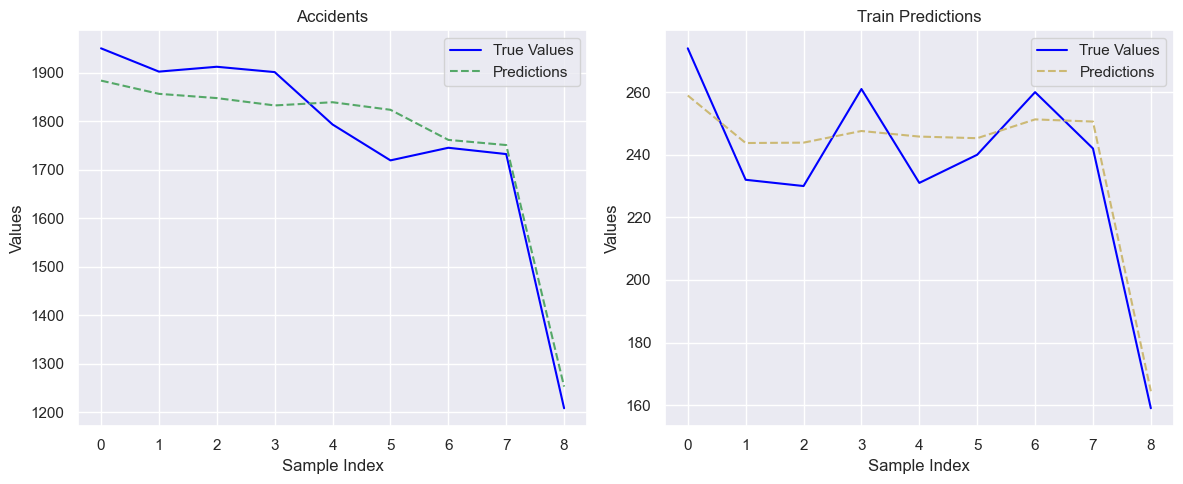

In [400]:
dummies = np.zeros((X_train.shape[0], shape_dim))
dummies[:, :2] = train_testing(
    [model1, model2, model3, model4, model5], train_loader, loss_function, device
)
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, :2])

dummies = np.zeros((X_train.shape[0], shape_dim))
dummies[:, :2] = y_train
dummies = scaler.inverse_transform(dummies)

y_train_c = dc(dummies[:, :2])


import matplotlib.pyplot as plt
import numpy as np

true_values_train = y_train_c

# Create subplots for each dimension
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for the first dimension
axes[0].plot(true_values_train[:, 0], label='True Values', color='blue')
axes[0].plot(train_predictions[:, 0], label='Predictions', color='g', linestyle='dashed')
axes[0].set_title('Accidents')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Values')
axes[0].legend()

# Plot for the second dimension
axes[1].plot(true_values_train[:, 1], label='True Values', color='blue')
axes[1].plot(train_predictions[:, 1], label='Predictions', color='y', linestyle='dashed',)
axes[1].set_title('Fatalities')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Values')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.title("Train Predictions")
plt.show()


# **Model Evaluation**

In [401]:
dummies = np.zeros((X_test.shape[0], shape_dim))
dummies[:, :2] = test_function([model1,model2,model3,model4,model5],test_loader,loss_function,device)
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, :2])
dummies = np.zeros((X_test.shape[0], shape_dim))
dummies[:, :2] = y_test
dummies = scaler.inverse_transform(dummies)

y_test_c = dc(dummies[:, :2])

true_values = y_test_c

print(test_predictions,true_values)

Val Loss for model model1: 1.28028
***************************************************

Val Loss for model model2: 0.54753
***************************************************

Val Loss for model model3: 0.27006
***************************************************

Val Loss for model model4: 0.77709
***************************************************

Val Loss for model model5: 0.81316
***************************************************

[[1511.07142028  215.15404292]] [[1447.00000119  191.99999967]]


In [402]:
test_true = np.vstack([true_values_train,true_values])
test = np.vstack([train_predictions,test_predictions])

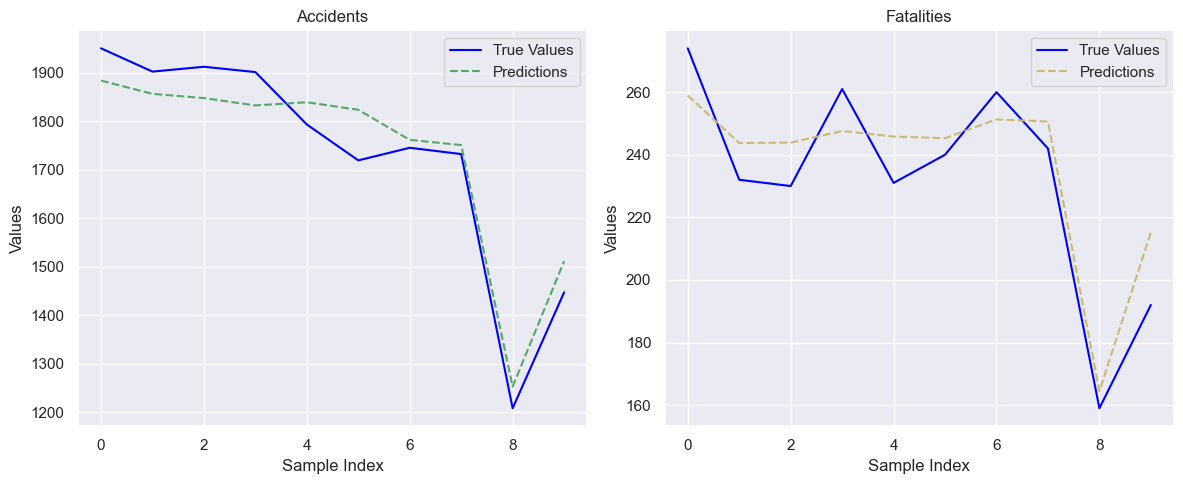

In [403]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for the first dimension
axes[0].plot(test_true[:, 0], label='True Values', color='blue')
axes[0].plot(test[:, 0], label='Predictions', color='g', linestyle='dashed')
axes[0].set_title('Accidents')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Values')
axes[0].legend()

# Plot for the second dimension
axes[1].plot(test_true[:, 1], label='True Values', color='blue')
axes[1].plot(test[:, 1], label='Predictions', color='y', linestyle='dashed')
axes[1].set_title('Fatalities')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Values')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [404]:
test_dataset[-1][0].unsqueeze(0)

tensor([[[ 0.5000],
         [-0.7798],
         [-1.0000],
         [-0.9019],
         [-1.0000]]])

In [405]:
# Initialize the input with the first batch of test data
input_data = torch.Tensor(np.array([shifted_df_as_np[-1][0],shifted_df_as_np[-1][2],shifted_df_as_np[-1][1],shifted_df_as_np[-1][3],0]).reshape(-1,1)).unsqueeze(0)
# np.array([shifted_df_as_np[-1][0],shifted_df_as_np[-1][2],shifted_df_as_np[-1][1],shifted_df_as_np[-1][3],0]).reshape(-1,1)  # Replace with your actual initial input data
print(input_data.shape)
# Number of predictions to make
num_predictions =1

# List to store the predictions
all_predictions = []
models =  [model1, model2, model3, model4, model5]
# Loop for making predictions recursively
for _ in range(num_predictions):
    # Convert the input_data to a PyTorch tensor
    input_tensor = torch.tensor(input_data, dtype=torch.float).to(device)
    # Make predictions using your model
    with torch.inference_mode():
        test_predictions = [
        model(input_tensor.to(device)).detach().cpu().numpy() for model in models
    ]

    weights = [2. / loss for loss in losses]

    weights = [w / sum(weights) for w in weights]
    ensemble_prediction = sum(w * p for w, p in zip(weights, test_predictions))


final_predictions = torch.tensor(ensemble_prediction, dtype=torch.float)


torch.Size([1, 5, 1])


C:\Users\user\AppData\Local\Temp\ipykernel_7264\2441376304.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_data, dtype=torch.float).to(device)


In [406]:
final_predictions

tensor([[0.3827, 0.5193]])

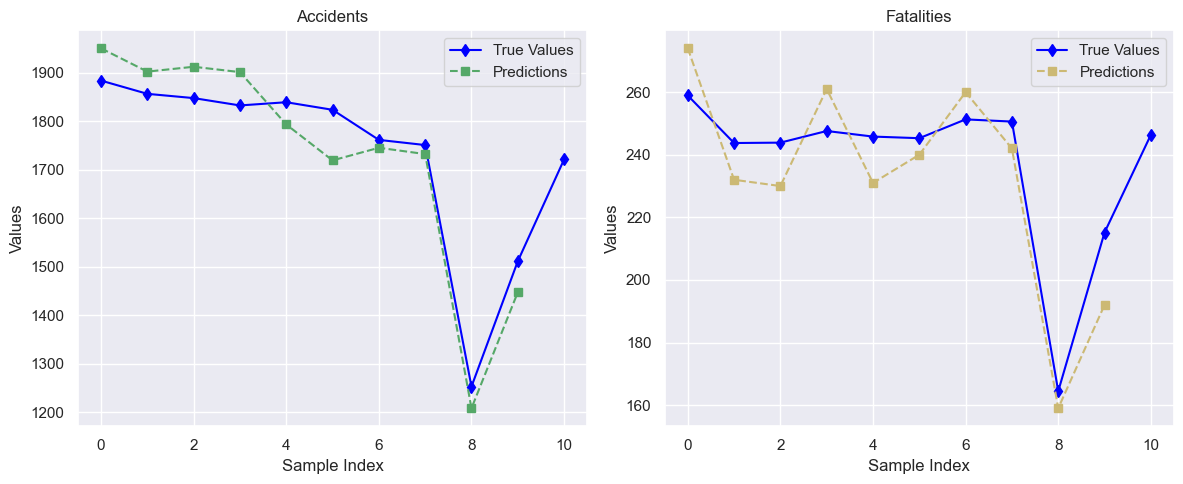

In [407]:
dummies = np.zeros((X_test.shape[0], shape_dim))
dummies[:, :2] = final_predictions
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, :2])
test2 = np.vstack([test,test_predictions])
true_values = test_true

# Create subplots for each dimension
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for the first dimension
axes[0].plot(test2[:, 0], label='True Values', color='blue',marker='d')
axes[0].plot(true_values[:, 0], label='Predictions', color='g', linestyle='dashed',marker='s')
axes[0].set_title('Accidents')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Values')
axes[0].legend()

# Plot for the second dimension
axes[1].plot(test2[:, 1], label='True Values', color='blue',marker='d')
axes[1].plot(true_values[:, 1], label='Predictions', color='y', linestyle='dashed',marker='s')
axes[1].set_title('Fatalities')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Values')
axes[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [409]:
torch.save(model1.state_dict(), f'Models/model1.pt')
torch.save(model2.state_dict(), f'Models/model2.pt')
torch.save(model3.state_dict(), f'Models/model3.pt')
torch.save(model4.state_dict(), f'Models/model4.pt')
torch.save(model5.state_dict(), f'Models/model5.pt')